Dataset loaded successfully.
Data preprocessing complete.
Data split into training (5625 rows) and testing (1407 rows) sets.
Features scaled successfully.

Tuning hyperparameters with GridSearchCV...
Best parameters found: {'C': 1}

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.91      0.70      0.79      1033
       Churn       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407


--- Confusion Matrix ---


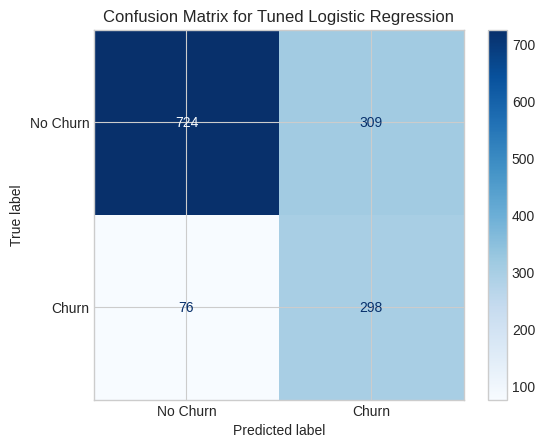


--- Learning Curve with Error Rate ---


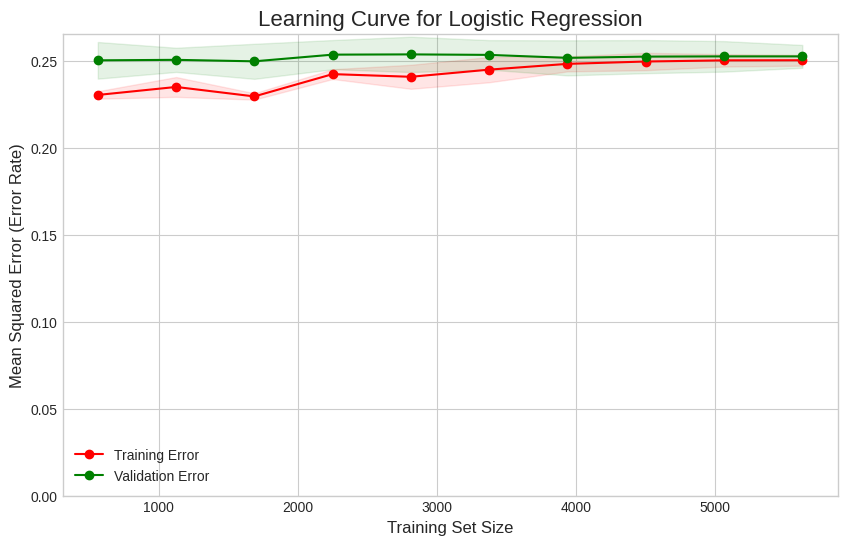

In [4]:
# ===================================================================
# 1. IMPORT LIBRARIES
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ===================================================================
# 2. LOAD AND PREPARE DATA
# ===================================================================
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-Telco-Customer-Churn.csv' not found.")
    print("Please make sure the dataset file is in the same directory as this script.")
    exit()

# --- Data Cleaning and Preprocessing ---
# Drop the unique customer ID as it's not a predictive feature
df = df.drop("customerID", axis=1)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# 'Churn' to binary (1 for 'Yes', 0 for 'No')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Churn', axis=1)
y = df['Churn']

# One-Hot Encode all categorical features
X = pd.get_dummies(X, drop_first=True)
print("Data preprocessing complete.")

# ===================================================================
# 3. SPLIT DATA INTO TRAINING AND TESTING SETS
# ===================================================================
# use stratify=y to ensure the train/test split has the same proportion of churners
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")

# ===================================================================
# 4. SCALE NUMERICAL FEATURES
# ===================================================================
# fit the scaler ONLY on the training data to prevent data leakage from the test set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler for the test data
print("Features scaled successfully.")

# ===================================================================
# 5. TUNE AND TRAIN THE LOGISTIC REGRESSION MODEL
# ===================================================================
print("\nTuning hyperparameters with GridSearchCV...")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best hyperparameter 'C'
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='f1',
    n_jobs=-1 # Use all available CPU cores
)

# Train the model on the SCALED training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model found by the grid search
best_lr_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# ===================================================================
# 6. EVALUATE THE FINAL MODEL
# ===================================================================
# Make predictions on the SCALED test data
y_pred = best_lr_model.predict(X_test_scaled)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Tuned Logistic Regression")
plt.show()

# ===================================================================
# 7. GENERATE AND PLOT LEARNING CURVE (WITH ERROR RATE)
# ===================================================================
print("\n--- Learning Curve with Error Rate ---")

pipe_lr = make_pipeline(StandardScaler(), best_lr_model)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipe_lr,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_errors_mean = -np.mean(train_scores, axis=1)
validation_errors_mean = -np.mean(validation_scores, axis=1)
train_errors_std = np.std(train_scores, axis=1)
validation_errors_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

# Plot the mean error lines
plt.plot(train_sizes, train_errors_mean, 'o-', color="r", label="Training Error")
plt.plot(train_sizes, validation_errors_mean, 'o-', color="g", label="Validation Error")

# Plot the shaded variance area
plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                 train_errors_mean + train_errors_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_errors_mean - validation_errors_std,
                 validation_errors_mean + validation_errors_std, alpha=0.1, color="g")

# Add titles and labels
plt.title("Learning Curve for Logistic Regression", fontsize=16)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Squared Error (Error Rate)", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.ylim(bottom=0) # Error rate cannot be negative
plt.show()

